In [69]:
pip install docplex

In [70]:
pip install cplex

In [71]:
import pandas as pd
import numpy as np
import sys
try:
    import cplex
except:
    if hasattr(sys, 'real_prefix'):
        !pip install cplex
    else:
        !pip install --user cplex
from docplex.mp.model import Model
import matplotlib.pyplot as plt

class Storage:
  def __init__(self,maxPow,maxCap,minSOC,maxSOC,startSOC,finSOC,chgEff,disEff):
    self.maxPow = maxPow
    self.maxCap = maxCap
    self.maxSOC = maxSOC
    self.minSOC = minSOC
    self.startSOC = startSOC
    self.finSOC = finSOC
    self.chgEff = chgEff
    self.disEff = disEff


[6468.8676568  6280.96620126 6206.9952925  6223.9533033  6438.4669116
 6748.0036033  7084.057331   7277.21641    7470.736003   7917.86659
 8466.36117    8548.66798    8534.69122    8524.63483    8368.9494
 8559.29754    8148.32015    7969.77906    7890.392226   7539.009241
 7258.774968   7014.230589   6837.380251   6633.137228  ]


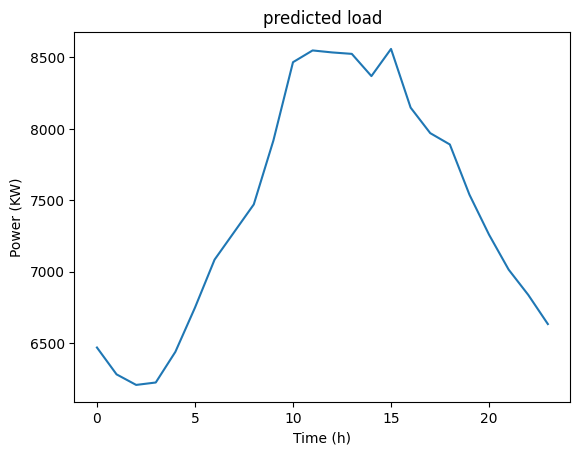

In [72]:
# 여름철 기준 전기료 (교육용(을) 고압B 선택2)
# 모델로 예측한 2023/8/19 태양광 발전량(pv), 전기사용량(load)

price = [70.5,70.5,70.5,70.5,
         70.5,70.5,70.5,70.5,
         114.0,114.0,114.0,176.9,
         114.0,176.9,176.9,176.9,
         176.9,176.9,114.0,114.0,
         114.0,114.0,70.5,70.5]
pv_predict = [ -1.1356568,0.48379874,2.1337075,3.8026967,
       5.8920884,7.2973967,9.510069,16.23459,
        23.237597,180.41841,270.73883,196.10402,
        331.62378,334.84317,370.8496,112.38946,
        306.82285,242.99594,48.127274,20.990759,
        12.868032,9.379811,6.865749,4.237772]
load_predict = [6467.732,6281.45,6209.129,6227.756,
         6444.359,6755.301,7093.5674,7293.451,
         7493.9736,8098.285,8737.1,8744.772,
         8866.315,8859.478,8739.799,8671.687,
         8455.143,8212.775,7938.5195,7560.0,
         7271.643,7023.6104,6844.246,6637.375]

# ESS 저장장치 생성
# 최대전력, 최대용량, 최소SOC, 최대SOC, 시작SOC, 종료SOC, 충전효율, 방전효율

ESS = Storage(250,750,0.2,0.8,0.5,0.5,1.0,0.93)
timeNum = len(load_predict)
load = np.array(load_predict)-np.array(pv_predict)
print(load)
plt.plot(load)
plt.title('predicted load')
plt.xlabel('Time (h)')
plt.ylabel('Power (KW)')
plt.show()

In [73]:
# 변수 생성 - 충전/방전량, 충전상태/방전상태
model = Model()
Pchg = model.continuous_var_list(timeNum,lb=0,ub=250)
Pdis = model.continuous_var_list(timeNum,lb=0,ub=250)
Uchg = model.binary_var_list(timeNum)
Udis = model.binary_var_list(timeNum)

# 제약조건 설정
# 최대/최소 출력, 충전/방전상태 제어, 방전량 상한

for i in range(0,timeNum):
  model.add_constraint(Pdis[i]<=Udis[i]*ESS.maxPow)
  model.add_constraint(Pchg[i]<=Uchg[i]*ESS.maxPow)
  model.add_constraint(Udis[i]+Uchg[i]<=1)
  model.add_constraint(Udis[i]<=load[i])

# 최대/최소/시작/종료 SOC상태 제약

for i in range(0,timeNum):
  model.add_constraint(ESS.startSOC-sum((Pdis[k]/ESS.disEff)/ESS.maxCap for k in range(0,i+1))
                   + sum((Pchg[k]*ESS.chgEff)/ESS.maxCap for k in range(0,i+1)) <= ESS.maxSOC
  )
  model.add_constraint(ESS.startSOC-sum((Pdis[k]/ESS.disEff)/ESS.maxCap for k in range(0,i+1))
                   + sum((Pchg[k]*ESS.chgEff)/ESS.maxCap for k in range(0,i+1)) >= ESS.minSOC
  )


model.add_constraint(ESS.startSOC-sum((Pdis[k]/ESS.disEff)/ESS.maxCap for k in range(0,timeNum))
                 + sum((Pchg[k]*ESS.chgEff)/ESS.maxCap for k in range(0,timeNum)) == ESS.finSOC
)



docplex.mp.LinearConstraint[](0.001x1+0.001x2+0.001x3+0.001x4+0.001x5+0.001x6+0.001x7+0.001x8+0.001x9+0.001x10+0.001x11+0.001x12+0.001x13+0.001x14+0.001x15+0.001x16+0.001x17+0.001x18+0.001x19+0.001x20+0.001x21+0.001x22+0.001x23+0.001x24-0.001x25-0.001x26-0.001x27-0.001x28-0.001x29-0.001x30-0.001x31-0.001x32-0.001x33-0.001x34-0.001x35-0.001x36-0.001x37-0.001x38-0.001x39-0.001x40-0.001x41-0.001x42-0.001x43-0.001x44-0.001x45-0.001x46-0.001x47-0.001x48+0.500,EQ,0.5)

In [74]:
# 전기요금 목적함수

model.set_objective('min',sum((load[i]+Pchg[i]-Pdis[i])*price[i] for i in range(0,timeNum)))
solution = model.solve()

print(f"최소 전기요금 : {model.objective_value} 원")

solPdis = np.zeros([timeNum])
solPchg = np.zeros([timeNum])
solUdis = np.zeros([timeNum])
solUchg = np.zeros([timeNum])

schedule = np.zeros([timeNum])

for i in range(0,timeNum):
  solPdis[i] = solution.get_value(Pdis[i])
  solPchg[i] = solution.get_value(Pchg[i])
  solUdis[i] = solution.get_value(Udis[i])
  solUchg[i] = solution.get_value(Uchg[i])

  schedule[i] = ESS.startSOC -sum((solPdis[k]/ESS.disEff)/ESS.maxCap for k in range(0,i+1))+sum((solPchg[k]*ESS.chgEff)/ESS.maxCap for k in range(0,i+1))


최소 전기요금 : 20556756.685129583 원


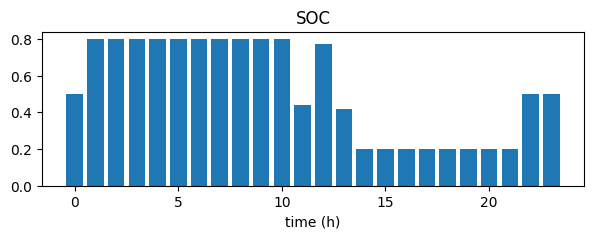

In [75]:
plt.figure(figsize=(7, 2))
plt.bar(range(0,timeNum), schedule)
plt.title('SOC')
plt.xlabel('time (h)')
plt.show()

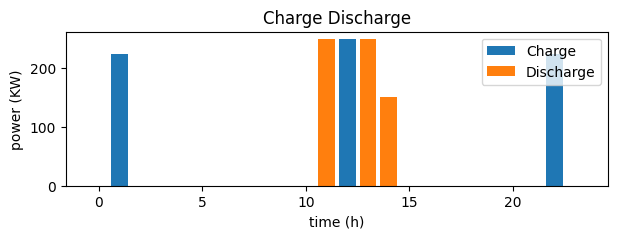

In [76]:
plt.figure(figsize=(7, 2))
plt.bar(range(0,timeNum),solPchg,label='Charge')
plt.bar(range(0,timeNum),solPdis,label='Discharge')
plt.ylabel('power (KW)')
plt.title('Charge Discharge')
plt.xlabel('time (h)')
plt.legend()
plt.show()